In [80]:
!nvidia-smi

Sat Jan 15 11:12:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |   1371MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import argparse
import glob
import os

import torch
import tqdm
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [83]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=200)
parser.add_argument("--image_size", type=int, default=256)
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--lr", type=float, default=2e-4)
parser.add_argument("--decay_start", type=int, default=100)
parser.add_argument("--weight_identity", type=float, default=5.0)  # 同一性損失の重みづけ
parser.add_argument("--weight_cycle", type=float, default=10.0)
parser.add_argument("--beta1", type=float, default=0.5)
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=1, beta1=0.5, decay_start=100, image_size=256, lr=0.0002, n_epoch=200, weight_cycle=10.0, weight_identity=5.0)


In [84]:
class ImageDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.file_A = glob.glob("/content/drive/MyDrive/data/horse2zebra/trainA/*.jpg")
        self.file_B = glob.glob("/content/drive/MyDrive/data/horse2zebra/trainB/*.jpg")
        self.transform = transform
    
    def __getitem__(self, index):
        # 一部モノクロ画像が入っててエラーとなるので、そこの処理もする
        imgA = self.transform(Image.open(self.file_A[index % len(self.file_A)]))
        while True:
            random_index = np.random.randint(0, len(self.file_B) - 1)
            imgB = self.transform(Image.open(self.file_B[random_index % len(self.file_B)]))
            C, H, W = imgB.size()
            if C == 3:
                break
        return {"A": imgA, "B": imgB}

    def __len__(self):
        return max(len(self.file_A), len(self.file_B))

class DecayLR(object):
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
    
    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [85]:
class ReplayBuffer(object):
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    # なんでこの方式でうまくいくんだっけ？直感的な説明ある？
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)   # バッチの次元を追加しておく必要があるので、0番目に次元を付与する
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if np.random.rand() > 0.5:
                    i = np.random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
            return torch.cat(to_return)

In [86]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
        )
    
    def forward(self, x):
        out = self.conv_layers(x)
        out += x    # ここが skip connection ?
        return out

In [87]:
class Generator(nn.Module):
    def __init__(self, res_block, in_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.res_block = res_block(256)
        self.transformer = nn.ModuleList([  # 9 層積み重ねる
            res_block(256),
            res_block(256),
            res_block(256),
            res_block(256),
            res_block(256),
            res_block(256),
            res_block(256),
            res_block(256),
            res_block(256),
        ])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.encoder(x)
        for func in self.transformer:
            out = func(out)
        out = self.decoder(out)
        return out

In [88]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_layer(3, 64, 4, 2, 1, False)
        self.conv2 = self.conv_layer(64, 128, 4, 2, 1, True)
        self.conv3 = self.conv_layer(128, 256, 4, 2, 1, True)
        self.conv4 = self.conv_layer(256, 512, 4, 1, 1, True)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, padding=1)

    @staticmethod
    def conv_layer(in_channels, out_channels, kernel_size, stride, padding, has_norm=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
        if has_norm:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        B, C, H, W = out.size()
        out = F.avg_pool2d(out, (H, W)) # 1*1 に Average Pooling
        out = out.view(B, -1)   # 1次元化する
        return out


In [89]:
def weights_init(m):
    # m means model
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)   # initialize using normal distribution
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   # initialize using normal distribution
        nn.init.constant_(m.bias.data, 0)   # initialize using normal distribution


In [90]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(int(opt.image_size * 1.12), Image.BICUBIC),
    transforms.RandomCrop(opt.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [91]:
dataset = ImageDataset(transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size,
                        shuffle=True)

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
device

device(type='cuda')

In [94]:
netG_A2B = Generator(ResidualBlock).to(device)
netG_B2A = Generator(ResidualBlock).to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

In [95]:
netG_A2B.apply(weights_init)
netG_B2A.apply(weights_init)
netD_A.apply(weights_init)
netD_B.apply(weights_init)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))

In [96]:
adversarial_loss = torch.nn.MSELoss().to(device)
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)

In [97]:
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizer_G = optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                        lr=opt.lr, betas=(opt.beta1, 0.999))

In [98]:
lr_lambda = DecayLR(opt.n_epoch, 0, opt.decay_start).step
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)

In [99]:
import os

model_name = "CycleGAN"
f_path_result = "/content/drive/MyDrive/result/{}".format(model_name)
f_path_params = "/content/drive/MyDrive/params/{}".format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

In [104]:
def save_params(epoch, dir_path, model_list, model_name_list):
    for model, model_name in zip(model_list, model_name_list):
        file_path = dir_path + "/{model}_{epoch}".format(model=model_name, epoch=epoch)
        torch.save(model.state_dict(), file_path)

100%|██████████| 1334/1334 [07:38<00:00,  2.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, Loss D: 0.2095834070281024, Loss G GAN: 6.5823399107316805, 
        Loss G cycle: 0.41083816834923836, Loss G identity: 0.19763566017418965


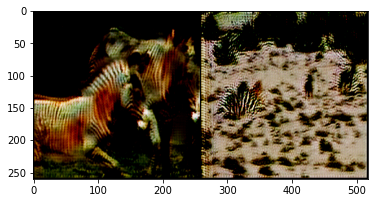

100%|██████████| 1334/1334 [07:21<00:00,  3.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, Loss D: 0.20403991385596462, Loss G GAN: 6.335708344715467, 
        Loss G cycle: 0.43186162968227737, Loss G identity: 0.18795995898768195


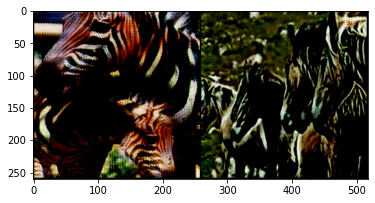

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2, Loss D: 0.20446721273741436, Loss G GAN: 6.040622650057837, 
        Loss G cycle: 0.42520018756777594, Loss G identity: 0.1781679506160911


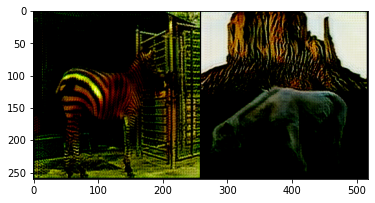

100%|██████████| 1334/1334 [07:14<00:00,  3.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3, Loss D: 0.203349277820345, Loss G GAN: 5.889079361662515, 
        Loss G cycle: 0.43422402468918725, Loss G identity: 0.17254772295022028


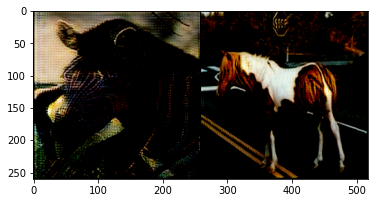

100%|██████████| 1334/1334 [07:14<00:00,  3.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4, Loss D: 0.20017939188149883, Loss G GAN: 5.7580514468889366, 
        Loss G cycle: 0.4212805025764723, Loss G identity: 0.16900909459427826


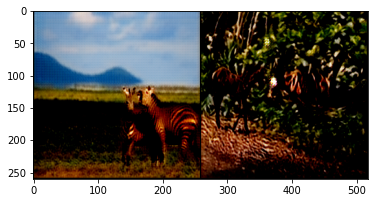

100%|██████████| 1334/1334 [07:14<00:00,  3.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5, Loss D: 0.19916649635644385, Loss G GAN: 5.614977516334454, 
        Loss G cycle: 0.4221623511156183, Loss G identity: 0.1645318761948256


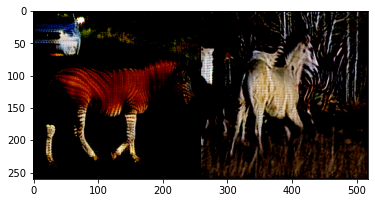

100%|██████████| 1334/1334 [07:14<00:00,  3.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6, Loss D: 0.1952505889314215, Loss G GAN: 5.551268770062047, 
        Loss G cycle: 0.4294927944666294, Loss G identity: 0.16207065212650634


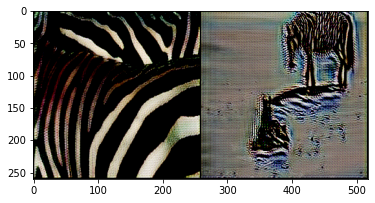

100%|██████████| 1334/1334 [07:14<00:00,  3.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7, Loss D: 0.19378411386754504, Loss G GAN: 5.4410469349713875, 
        Loss G cycle: 0.4328344399796097, Loss G identity: 0.1584577600470279


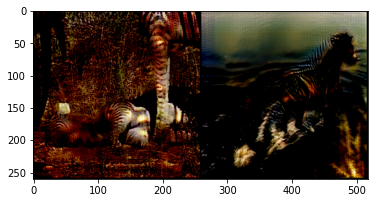

100%|██████████| 1334/1334 [07:15<00:00,  3.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8, Loss D: 0.18844878784495048, Loss G GAN: 5.357826303148913, 
        Loss G cycle: 0.43262513269869696, Loss G identity: 0.1557598067670949


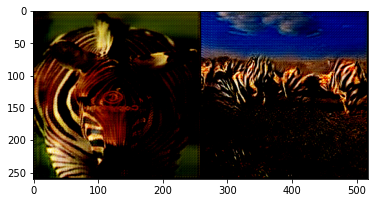

100%|██████████| 1334/1334 [07:15<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9, Loss D: 0.1907443368701328, Loss G GAN: 5.27474346832893, 
        Loss G cycle: 0.43082224868700975, Loss G identity: 0.15347169710789574


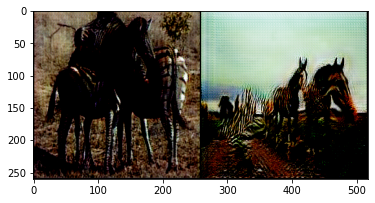

100%|██████████| 1334/1334 [07:15<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 10, Loss D: 0.19146356800730974, Loss G GAN: 5.245977290745439, 
        Loss G cycle: 0.42757129912501907, Loss G identity: 0.15230427640930064


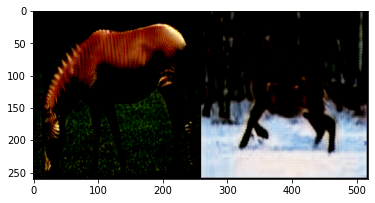

100%|██████████| 1334/1334 [07:15<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 11, Loss D: 0.1841764189448004, Loss G GAN: 5.134175898789287, 
        Loss G cycle: 0.4336860881584549, Loss G identity: 0.14848729102094582


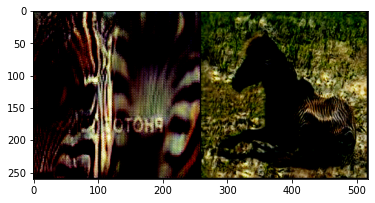

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 12, Loss D: 0.18445640643665553, Loss G GAN: 5.03897663320916, 
        Loss G cycle: 0.4347043773104774, Loss G identity: 0.14512694103997956


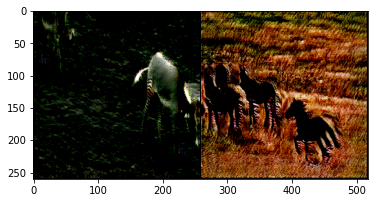

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 13, Loss D: 0.1840380310087807, Loss G GAN: 5.03673455275517, 
        Loss G cycle: 0.43650746974628535, Loss G identity: 0.14499098916483605


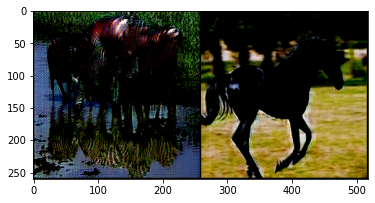

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 14, Loss D: 0.17889112362778695, Loss G GAN: 5.045635786728523, 
        Loss G cycle: 0.4412132699208319, Loss G identity: 0.14521480942454965


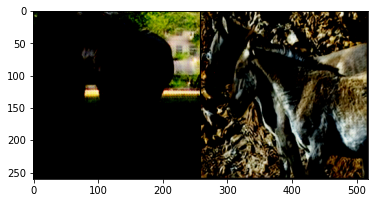

100%|██████████| 1334/1334 [07:16<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15, Loss D: 0.17799990521796363, Loss G GAN: 4.98318916389431, 
        Loss G cycle: 0.43253496739943187, Loss G identity: 0.14371887813259412


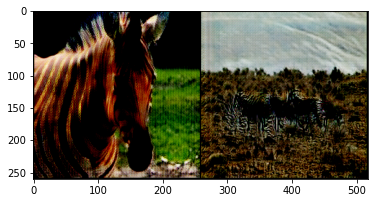

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 16, Loss D: 0.17295380295963778, Loss G GAN: 4.911081008289171, 
        Loss G cycle: 0.4466882450601411, Loss G identity: 0.14046217540119854


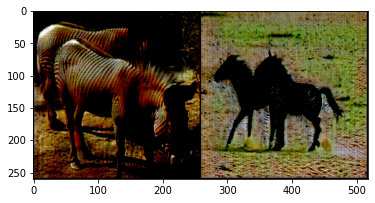

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 17, Loss D: 0.17766630225533767, Loss G GAN: 4.8435414718545005, 
        Loss G cycle: 0.43649551450361473, Loss G identity: 0.13886430916953077


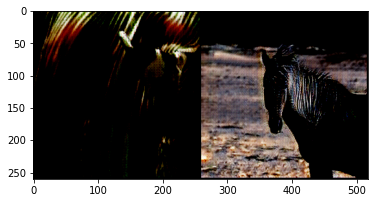

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 18, Loss D: 0.17561908586295352, Loss G GAN: 4.843801206913309, 
        Loss G cycle: 0.44617456926744886, Loss G identity: 0.13840658643675305


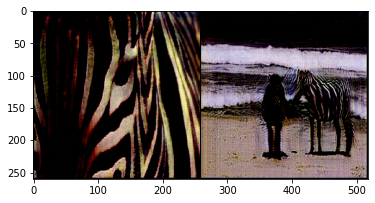

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 19, Loss D: 0.1772742232344548, Loss G GAN: 4.784187829476604, 
        Loss G cycle: 0.4371482655320878, Loss G identity: 0.13682410196642736


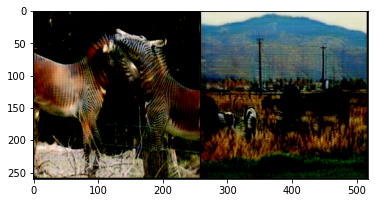

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20, Loss D: 0.17415322905479094, Loss G GAN: 4.701986695872969, 
        Loss G cycle: 0.44362990398860086, Loss G identity: 0.13367090957040997


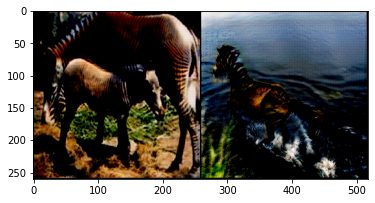

100%|██████████| 1334/1334 [07:16<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 21, Loss D: 0.16939683147222234, Loss G GAN: 4.727357768047338, 
        Loss G cycle: 0.4428144297519294, Loss G identity: 0.134811840082953


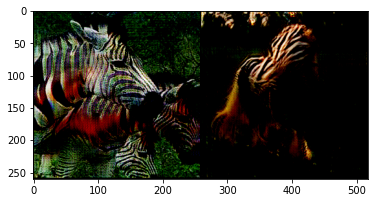

100%|██████████| 1334/1334 [07:16<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 22, Loss D: 0.1693089934949727, Loss G GAN: 4.70988312028516, 
        Loss G cycle: 0.4550428617050785, Loss G identity: 0.1335692926096371


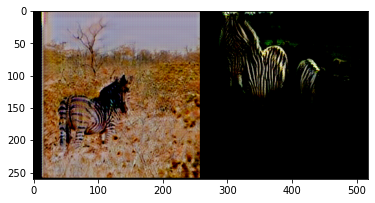

100%|██████████| 1334/1334 [07:17<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 23, Loss D: 0.1685368663537152, Loss G GAN: 4.627207797149132, 
        Loss G cycle: 0.4547168696948454, Loss G identity: 0.13088106638521538


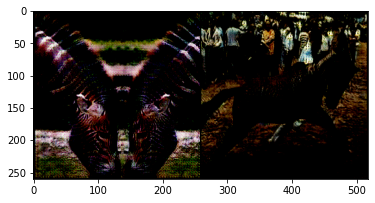

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 24, Loss D: 0.16690717361670368, Loss G GAN: 4.650627010050921, 
        Loss G cycle: 0.46322120870077405, Loss G identity: 0.1310620008865888


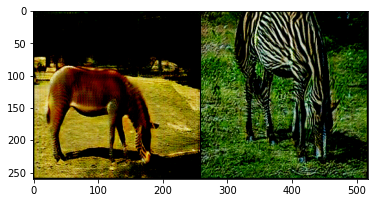

100%|██████████| 1334/1334 [07:17<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 25, Loss D: 0.17052258388600736, Loss G GAN: 4.556326839341216, 
        Loss G cycle: 0.449732166660496, Loss G identity: 0.12855297150969996


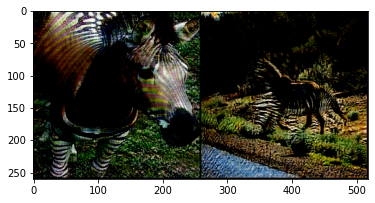

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 26, Loss D: 0.1677289740015655, Loss G GAN: 4.5805288830261, 
        Loss G cycle: 0.45520616145264037, Loss G identity: 0.1292542542416094


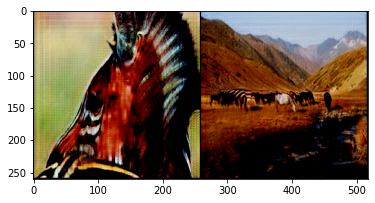

100%|██████████| 1334/1334 [07:16<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 27, Loss D: 0.1678241668812826, Loss G GAN: 4.507599490157132, 
        Loss G cycle: 0.44810704198841034, Loss G identity: 0.12698293768003516


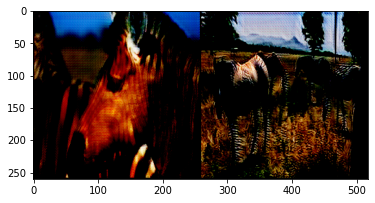

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 28, Loss D: 0.16309472165696445, Loss G GAN: 4.52042188941092, 
        Loss G cycle: 0.46398731480201033, Loss G identity: 0.12682621932492175


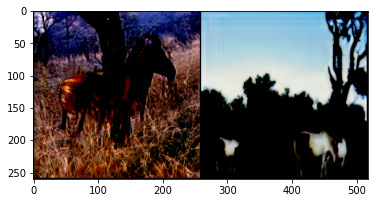

100%|██████████| 1334/1334 [07:16<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 29, Loss D: 0.16446539661927015, Loss G GAN: 4.515165627092078, 
        Loss G cycle: 0.46167782146126873, Loss G identity: 0.12652516696250243


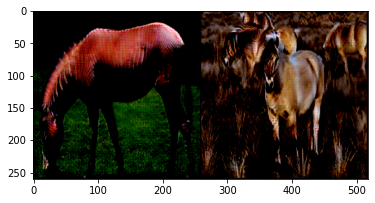

100%|██████████| 1334/1334 [07:16<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 30, Loss D: 0.16464772880265927, Loss G GAN: 4.421725488495434, 
        Loss G cycle: 0.4577612843464645, Loss G identity: 0.12379381438854083


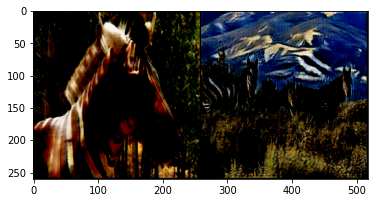

100%|██████████| 1334/1334 [07:16<00:00,  3.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 31, Loss D: 0.15751794166407945, Loss G GAN: 4.4839898878666595, 
        Loss G cycle: 0.473990791921545, Loss G identity: 0.12481870286926247


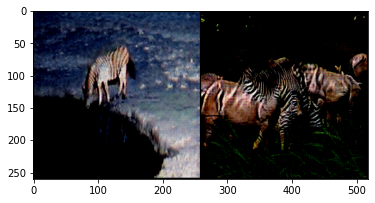

 80%|████████  | 1073/1334 [05:51<01:25,  3.06it/s]

In [ ]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

for epoch in range(0, opt.n_epoch):
    running_loss_D = 0.0
    running_loss_G = 0.0
    running_loss_G_GAN = 0.0
    running_loss_G_cycle = 0.0
    running_loss_G_identity = 0.0
    for data in tqdm.tqdm(dataloader, position=0):
        real_img_A = data["A"].to(device)
        real_img_B = data["B"].to(device)
        batch_size = real_img_A.size()[0]
        real_label = torch.ones([batch_size, 1]).to(device)
        fake_label = torch.zeros([batch_size, 1]).to(device)

        #
        # Train Generator
        #
        optimizer_G.zero_grad()
        # adversarial loss
        fake_img_A = netG_B2A(real_img_B)
        fake_img_B = netG_A2B(real_img_A)
        output_A = netD_A(fake_img_A)
        output_B = netD_B(fake_img_B)

        loss_GAN_A2B = adversarial_loss(output_B, real_label)
        loss_GAN_B2A = adversarial_loss(output_A, real_label)
        # Cycle loss
        cycle_img_A = netG_B2A(fake_img_B)
        cycle_img_B = netG_A2B(fake_img_A)

        loss_cycle_ABA = cycle_loss(cycle_img_A, real_img_A)
        loss_cycle_BAB = cycle_loss(cycle_img_B, real_img_B)
        # Identity loss
        identity_img_A = netG_B2A(real_img_A)
        identity_img_B = netG_A2B(real_img_B)

        loss_identity_A = identity_loss(identity_img_A, real_img_A)
        loss_identity_B = identity_loss(identity_img_B, real_img_B)

        lossG = (loss_GAN_A2B + loss_GAN_B2A 
                 + opt.weight_identity * (loss_identity_A + loss_identity_B)
                 + opt.weight_cycle * (loss_cycle_ABA + loss_cycle_BAB)
        )
        lossG.backward()
        optimizer_G.step()

        #
        # Train Descriminator
        #
        optimizer_D_A.zero_grad()
        optimizer_D_B.zero_grad()

        real_output_A = netD_A(real_img_A)
        real_output_B = netD_B(real_img_B)
        loss_DA_real = adversarial_loss(real_output_A, real_label)
        loss_DB_real = adversarial_loss(real_output_B, real_label)

        # fake の方に対して、buffer を使う
        fake_img_A = fake_A_buffer.push_and_pop(fake_img_A)
        fake_img_B = fake_B_buffer.push_and_pop(fake_img_B)
        fake_output_A = netD_A(fake_img_A.detach())
        fake_output_B = netD_B(fake_img_B.detach())

        loss_DA_fake = adversarial_loss(fake_output_A, fake_label)
        loss_DB_fake = adversarial_loss(fake_output_B, fake_label)

        loss_DA = (loss_DA_real + loss_DA_fake) * 0.5
        loss_DB = (loss_DB_real + loss_DB_fake) * 0.5

        loss_DA.backward()
        loss_DB.backward()
        optimizer_D_A.step()
        optimizer_D_B.step()

        # adding to running loss
        running_loss_D += (loss_DA.item() + loss_DB.item()) / 2.0
        running_loss_G += lossG.item()
        running_loss_G_GAN += (loss_GAN_A2B.item() + loss_GAN_B2A.item()) / 2.0
        running_loss_G_cycle += (loss_cycle_ABA.item() + loss_cycle_BAB.item()) / 2.0
        running_loss_G_identity += (loss_identity_A.item() + loss_identity_B.item()) / 2.0
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    running_loss_D /= len(dataloader)
    running_loss_G /= len(dataloader)
    running_loss_G_GAN /= len(dataloader)
    running_loss_G_cycle /= len(dataloader)
    running_loss_G_identity /= len(dataloader)

    loss_log = """epoch: {}, Loss D: {}, Loss G GAN: {}, 
        Loss G cycle: {}, Loss G identity: {}""".format(epoch, running_loss_D, running_loss_G, 
                                    running_loss_G_GAN, running_loss_G_cycle, running_loss_G_identity)
    print(loss_log)
    fake_imgs = torch.cat([fake_img_A, fake_img_B])
    grid_imgs = vutils.make_grid(fake_imgs.detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1, 2, 0)))
    plt.show()
    model_list = [netG_A2B, netG_B2A, netD_A, netD_B]
    model_name_list = ["netG_A2B", "netG_B2A", "netD_A", "netD_B"]
    save_params(epoch, f_path_params, model_list, model_name_list)


## 上の途中経過
左：シマウマ⇨馬  
右：馬⇨シマウマ